In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./housing.csv")
df = df[df["median_house_value"] < 500001]
df = df[df["housing_median_age"] < 52]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

exclude_map = ["longitude", "latitude"]
map_cols = [c for c in numeric_cols if c not in exclude_map]

target = "median_house_value"
exclude_corr = ["longitude", "latitude", target]
corr_cols = [c for c in numeric_cols if c not in exclude_corr]

In [3]:
# plot in map
def mapping(ax, name, df):
    x = df["longitude"]
    y = df["latitude"]
    z = df[name]

    sc = ax.scatter(x, y, c=z, cmap="viridis", alpha=0.4, s=10)
    ax.set_title(name)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)


def plot_all_maps(df, cols, ncols=3):
    nrows = int(np.ceil(len(cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        mapping(ax, col, df)

    # 余った axes を消す
    for ax in axes[len(cols):]:
        ax.axis("off")

    fig.suptitle("Geographical Distribution of Variables", fontsize=16)
    plt.tight_layout()
    plt.show()


def corr_and_fit(ax, x, y, x_name, y_name):
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 2 or np.std(x) == 0:
        ax.set_title(f"{y_name} vs {x_name}")
        ax.text(
            0.05, 0.95,
            "Not enough data",
            transform=ax.transAxes,
            va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )
        return np.nan, np.nan, np.nan

    # 相関
    corr = np.corrcoef(x, y)[0, 1]

    # 線形回帰（解析解：安定）
    slope = np.cov(x, y, bias=True)[0, 1] / np.var(x)
    intercept = y.mean() - slope * x.mean()

    # 回帰線
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept

    ax.scatter(x, y, alpha=0.2, s=10)
    ax.plot(x_fit, y_fit)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(f"{y_name} vs {x_name}")

    # ===== グラフ内に数値を表示 =====
    text = (
        f"slope     : {slope:.3e}\n"
        f"intercept : {intercept:.3e}\n"
        f"corr      : {corr:.3f}"
    )

    ax.text(
        0.05, 0.95,
        text,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(
            boxstyle="round",
            facecolor="white",
            edgecolor="gray",
            alpha=0.85,
        ),
    )

    return slope, intercept, corr


def plot_all_correlations(df, target, cols, ncols=3):
    nrows = int(np.ceil(len(cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    results = {}

    for ax, col in zip(axes, cols):
        slope, intercept, corr = corr_and_fit(
            ax,
            df[col],
            df[target],
            col,
            target,
        )
        results[col] = {
            "slope": slope,
            "intercept": intercept,
            "corr": corr,
        }

    for ax in axes[len(cols):]:
        ax.axis("off")

    fig.suptitle(f"{target} vs Other Variables", fontsize=16)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results).T

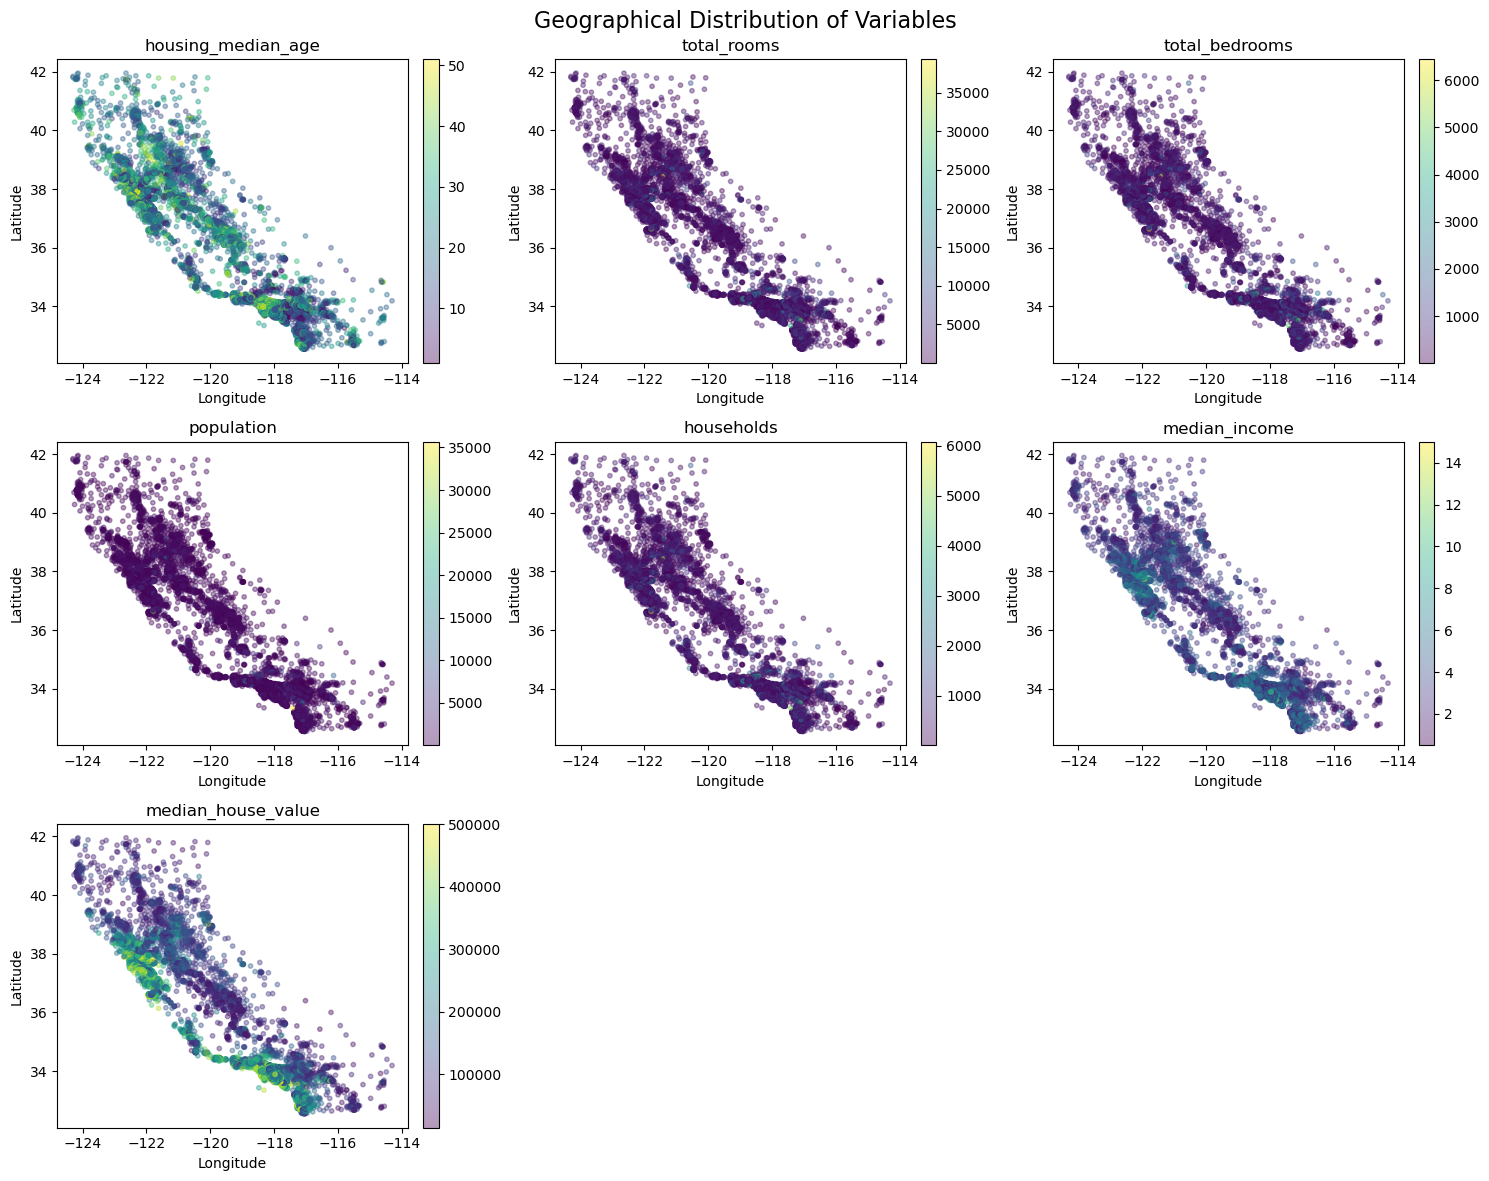

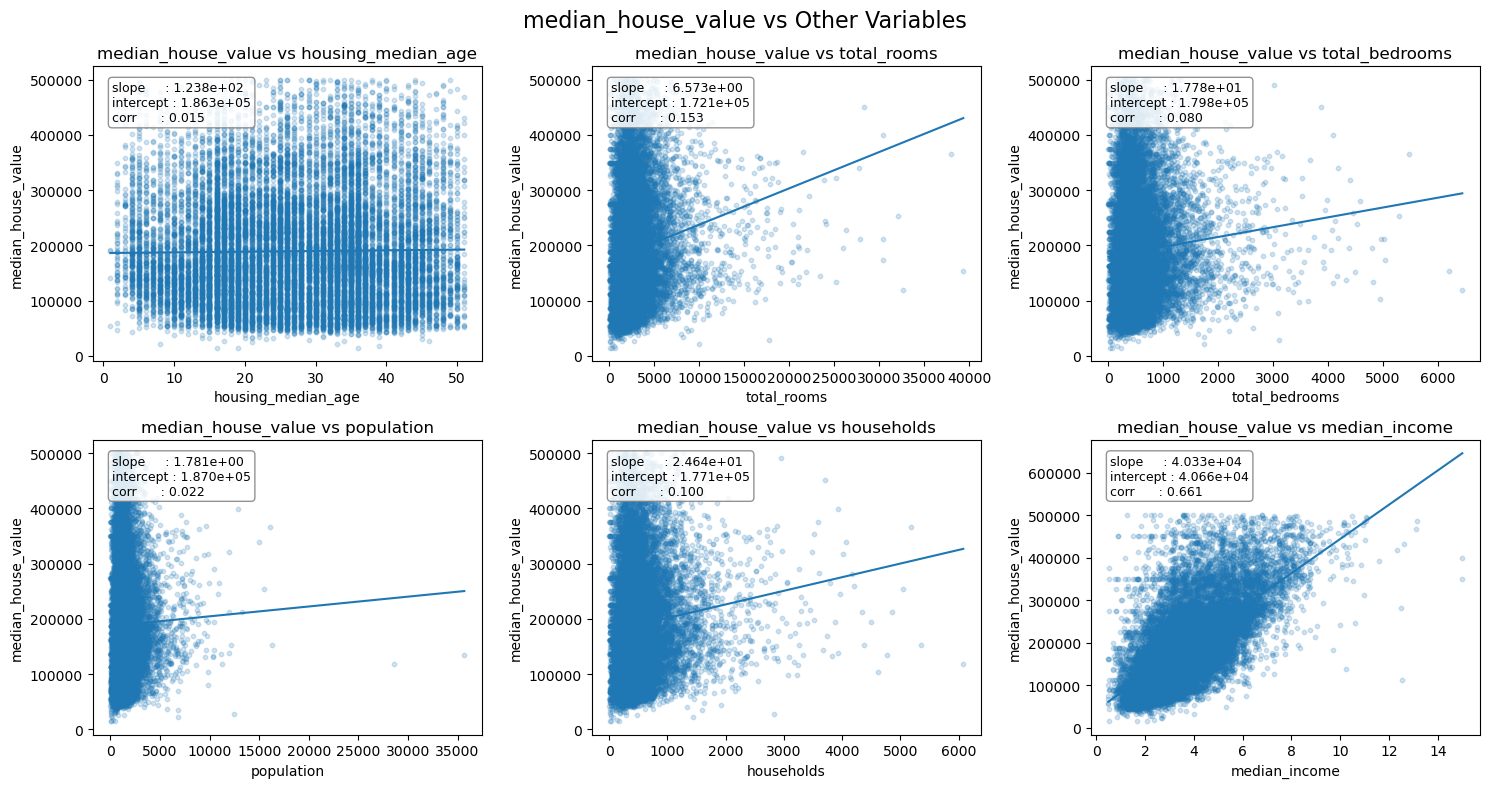

                           slope      intercept      corr
housing_median_age    123.776440  186267.643586  0.014772
total_rooms             6.573409  172064.223314  0.152606
total_bedrooms         17.777889  179821.114971  0.079721
population              1.780507  186989.563217  0.021616
households             24.642858  177071.259943  0.100220
median_income       40330.717052   40655.696970  0.661039


In [4]:
if __name__ == "__main__":
    # 地理分布を一括表示
    plot_all_maps(df, map_cols)

    # 相関 + 線形回帰
    summary = plot_all_correlations(df, target, corr_cols)
    print(summary)